# 10.07 Image Features

Feature extraction is likely the most important, time consuming and nerve eating
activity in a machine learning pipeline.
Given enough data (millions of samples) we can perform feature extraction automatically,
yet that isn't viable in most cases.
For different types of data specialized feature extraction techniques exist.
Images probably have the most extensive number of feature building techniques.

![Rembrandt](ol-rembrandt.svg)

<div style="text-align:right;"><sup>ol-rembrandt.svg</sup></div>

Working with images we have been using pixel values as input to our models.
That is one way of doing things but it isn't the most effective way in practice.
Years of computer vision research did produce techniques for feature extraction
that easily outperform any form of PCA or fold learning.

In the Python world the `scikit-image` is the framework for image manipulation using NumPy arrays.  
And it is integrated with `matplotlib` too, we import these things fro now.

In [1]:
import matplotlib.pyplot as plt

`scikit-image`, imported as `skimage`, has several test images, all are just NumPy arrays.

In [2]:
from skimage import data

camera = data.camera()
camera.shape

(512, 512)

A two dimensional NumPy array is a gray-scale image.

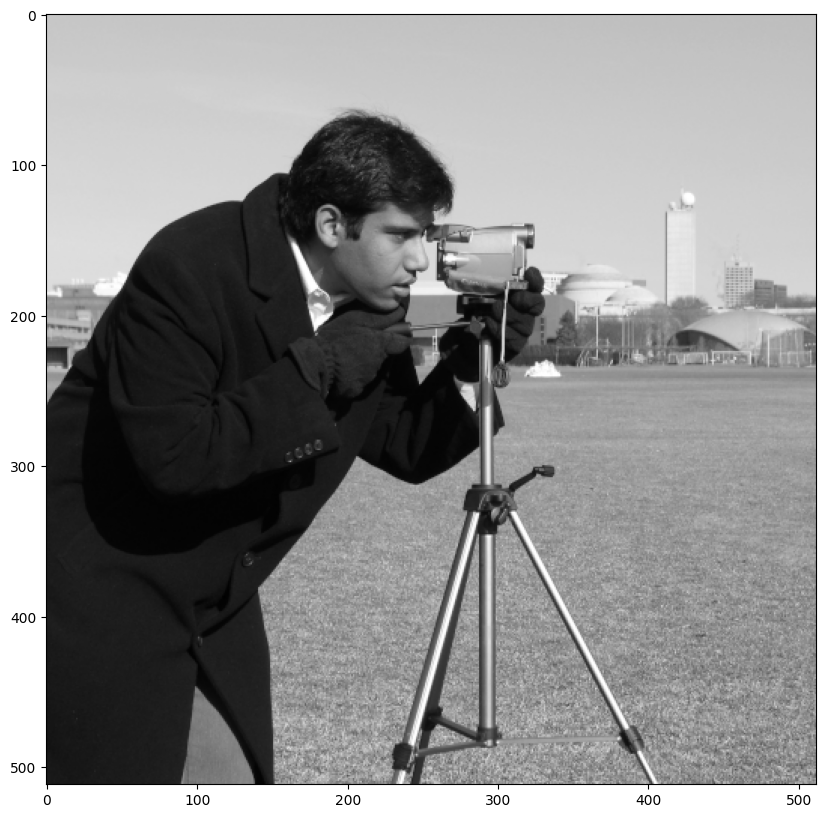

In [3]:
fit, ax = plt.subplots(figsize=(10, 10))
ax.imshow(camera, cmap='gray');

A color image is a three dimensional image where the last (rightmost)
dimension are the color channels (most often but not always RGB).
`skimage` tries to build standards for image representations as arrays,
their standards are:

| image                      | coordinates                   |
|:-------------------------- |:----------------------------- |
| 2D gray-scale              | (row, column)                 |
| 2D color image             | (row, column, channel)        |
| 3D gray-scale (e.g. video) | (frame, row, column)          |
| 3D color (e.g. video)      | (frame, row, column, channel) |

(400, 600, 3)

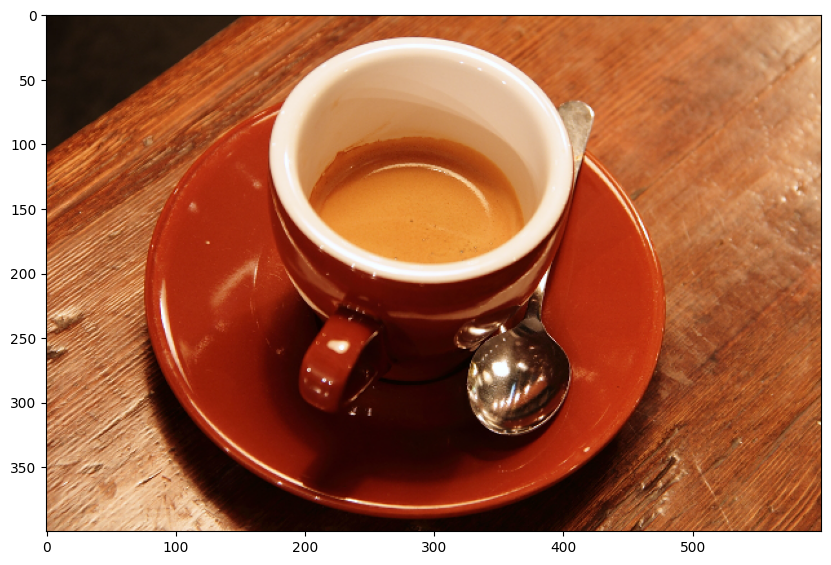

In [4]:
fit, ax = plt.subplots(figsize=(10, 10))
coffee = data.coffee()
ax.imshow(coffee)
coffee.shape

To be fair, videos are complicated to load into NumPy arrays.
This is mostly due to inter-frame compression in several video formats.
Tools, such as `moviepy` or `imageio`, can deal with several video formats
but if one can simply dismantle the video into a directory of frames it often produces better results.

Images can be read directly into NumPy arrays with `skimage`.
Most formats are supported, with a couple of special procedures to load TIFF and GIF files.

In [5]:
from skimage import io

tulp = io.imread('ol-rembrandt-tulp.png')

Again, this is just a NumPy array, therefore we can plot it.

(480, 624, 3)

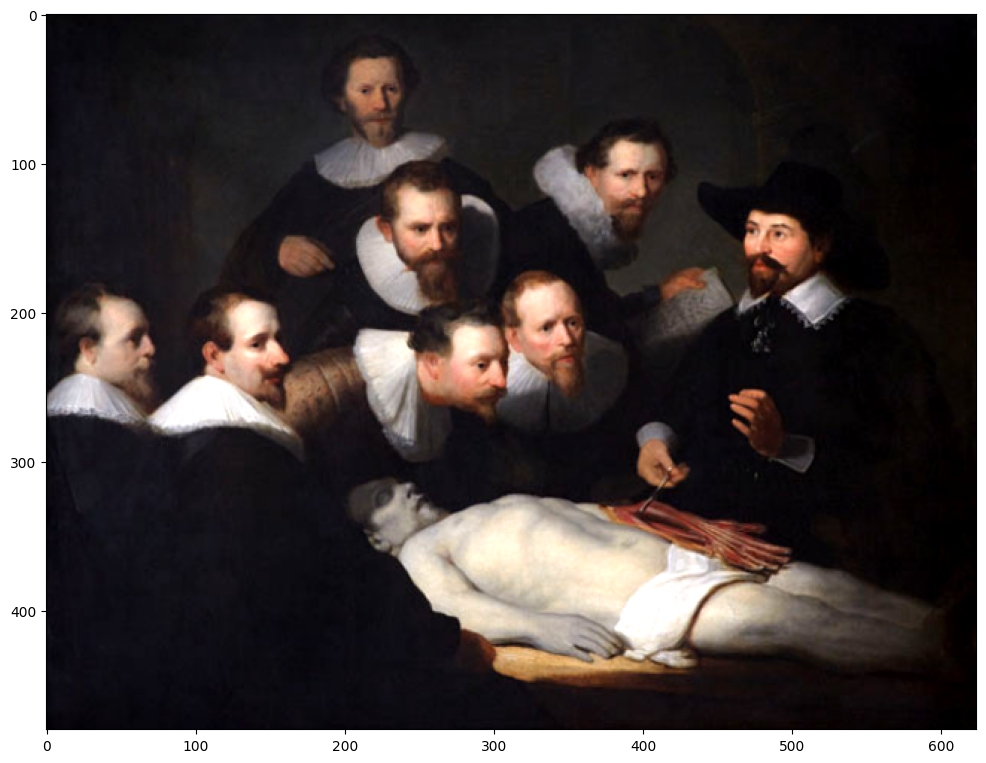

In [6]:
fit, ax = plt.subplots(figsize=(12, 12))
ax.imshow(tulp)
tulp.shape

The Anatomy Lesson of Dr Tulp is a rather difficult image to process
due to irregular lighting.
It hence is also a very interesting image to process.

You may have noticed that the $y$ coordinate of the displayed images is going from top to bottom.
This is the common representation in images, despite being different from a Cartesian graph.
The NumPy array we did just read is ordered in the way the axes above show.

We said that the last dimension of the array are the channels,
therefore separating the RGB channels is easy.

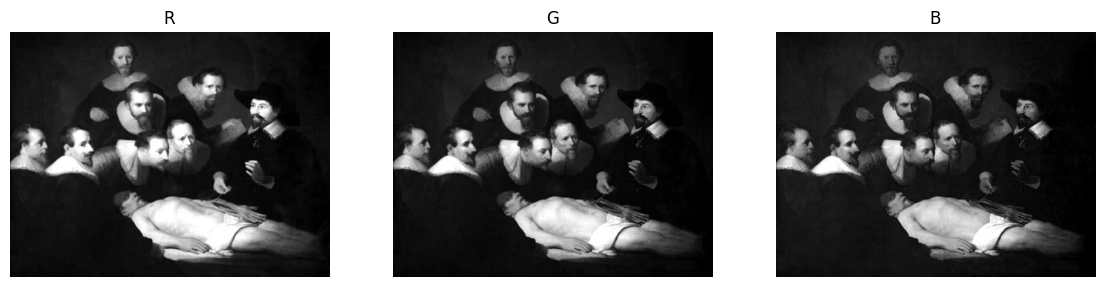

In [7]:
fit, ax = plt.subplots(1, 3, figsize=(14, 5))
component = ['R', 'G', 'B']
for i in range(3):
    ax.flat[i].imshow(tulp[:, :, i], cmap='gray')
    ax.flat[i].set_title(component[i])
    ax.flat[i].axis('off')

But RGB channels are device specific,
and, therefore, very poor for image features.

Instead, other representations such as HSV (Hue, Saturation and Value/Lightness) or LAB are both:
device independent and close to how a human sees an image.

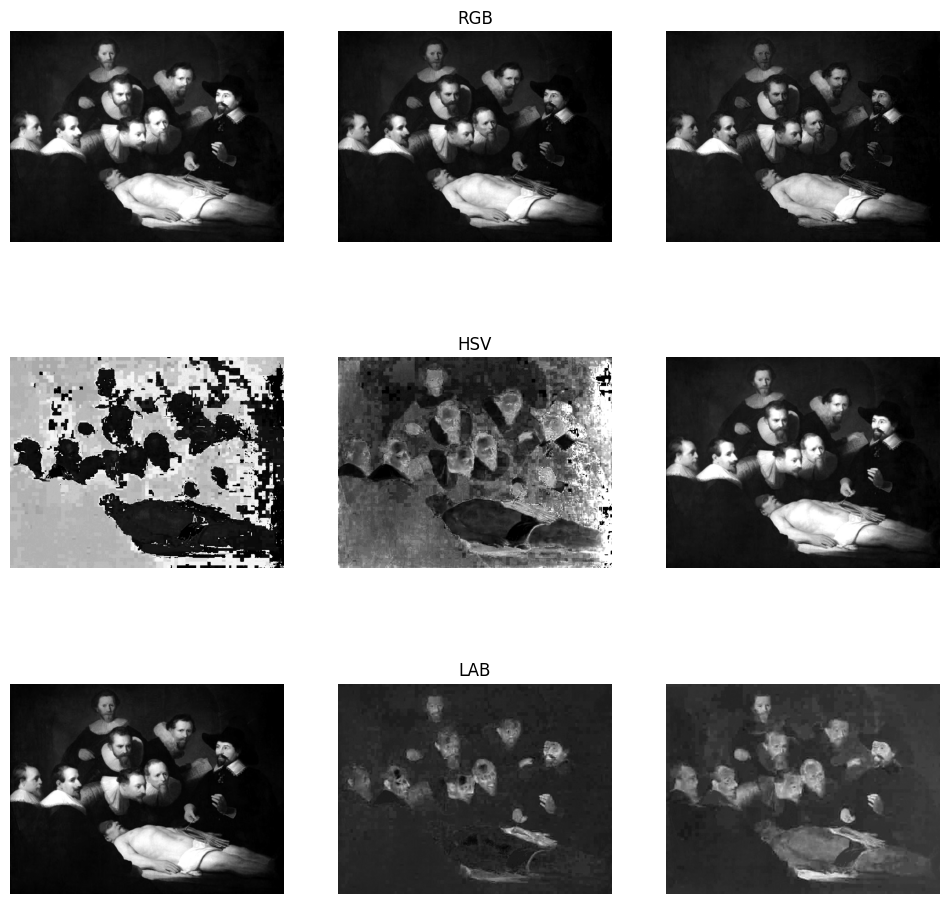

In [8]:
from skimage import color

tulp_hsv = color.rgb2hsv(tulp)
tulp_lab = color.rgb2lab(tulp)
fit, ax = plt.subplots(3, 3, figsize=(12, 12))
tulp_arr = [tulp, tulp_hsv, tulp_lab]
repr_arr = ['RGB', 'HSV', 'LAB']
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(tulp_arr[i][:, :, j], cmap='gray')
        if j == 1:
            ax[i, j].set_title(repr_arr[i])
        ax[i, j].axis('off')

The $V$ in HSV and the $L$ in LAB representations are actually
the transformation we perform when we convert an image to gray-scale.
On a decent piece of software that is,
bad software often does $R/3 + G/3 +B/3$.

`skimage`'s `feature` then has several features that make sense on the lightness ($L$) of an image.
The Canny filter is a feature that describes where the image changes the most.
It is a *kernel* that walks the image and differentiates between adjacent pixels.
The idea of a path in an image *changing most* is a way of saying
that we are suing a derivative.
High derivatives are then set to one and low ones to zero.

This kernel method on images is called a function *convolution*.
This is not to be confused with SVM kernels.
The `sigma=` argument is a sensitivity as to where draw the threshold
between white and black values.

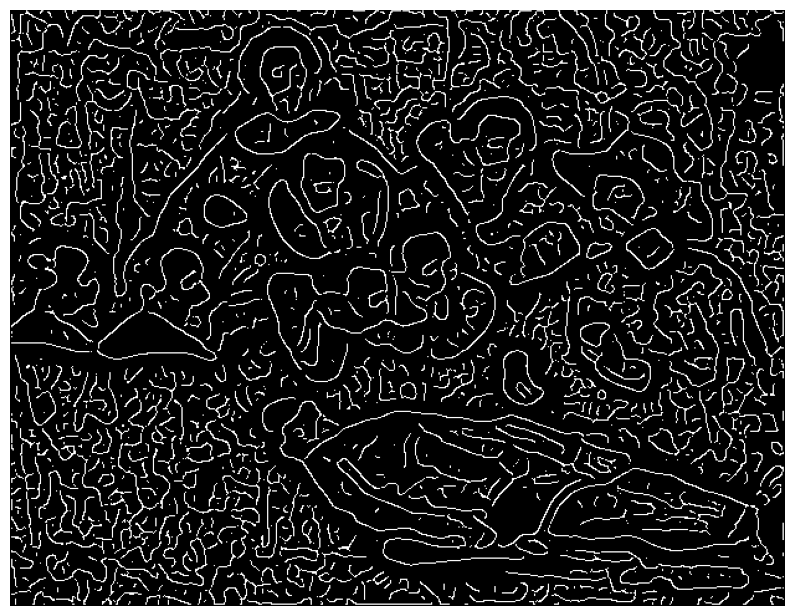

In [9]:
from skimage import feature

canny = feature.canny(tulp_lab[:, :, 0], sigma=3)
fit, ax = plt.subplots(figsize=(10, 10))
ax.imshow(canny, cmap='gray')
ax.axis('off');

The Sobel filter is similar to the Canny filter
but it keeps the scaled values of all derivatives instead of forcing them to zero and one.
Contrary to the Canny filter, Sobel does not have a parameter for image scaling
therefore we need to do it ourselves.

The LAB representation uses floating point numbers,
which is acceptable for `skimage` algorithms.
Yet `skimage` expects floating points representations to be scaled between
$-1$ and $1$ or between $0$ and $1$.
We scale the lightness channel between $0$ and $1$.

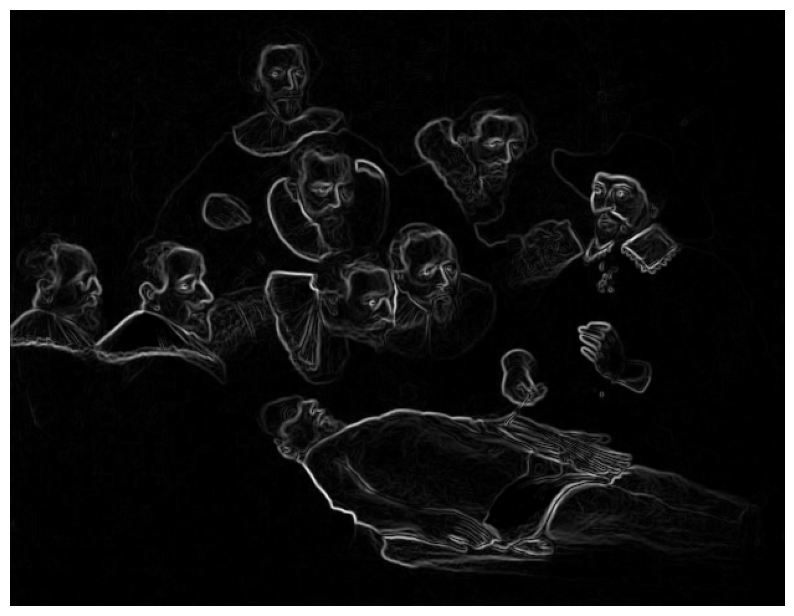

In [10]:
from skimage import filters

sobel = filters.sobel(tulp_lab[:, :, 0]/tulp_lab[:, :, 0].max())
fit, ax = plt.subplots(figsize=(10, 10))
ax.imshow(sobel, cmap='gray')
ax.axis('off');

In summary, taking the pixels as features of an image is just one
of many possibilities.
The pixels themselves are linear features,
which may give us trouble when modeling non-linear problems.
Filters such as the ones we saw and many, many others allow us
to deal with non-linearity in a similar way as the non-linear projections we saw.
But filters akin of these can also be understood,
or learned by models.

## References

- [SciKit Image Documentation][1]
- [The image used is Rembrandt's "Anatomy Lesson of Dr Tulp" - Image from the VADS' NIRP Project][2]

[1]: http://scikit-image.org/docs/stable/index.html "SciKit Image"
[2]: https://vads.ac.uk/collections/NIRP/index.php "VADS - NIRP"